# DSCI 632: Applied Cloud Computing
# Term Project: MLB Pitch Outcomes Classification Task

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate() 
sc = spark.sparkContext

## Exploratory Data Analysis (EDA)

### Importing the Data

First, we must import the data. We will upload it to the DBFS and then read it using spark.read.csv.

We know that this file has a header and we want to infer the schema, so we leverage these arguments.

In [0]:
df_pitch_2015_2018 = spark.read.csv('dbfs:/FileStore/shared_uploads/s.oyesiku@gmail.com/pitches.csv', header = True, inferSchema = True)

Next, let us take a look at the datatypes within the resultant dataframe. We have 40 total fields to examine.

In [0]:
df_pitch_2015_2018.dtypes

Out[6]: [('px', 'double'),
 ('pz', 'double'),
 ('start_speed', 'double'),
 ('end_speed', 'double'),
 ('spin_rate', 'double'),
 ('spin_dir', 'double'),
 ('break_angle', 'double'),
 ('break_length', 'double'),
 ('break_y', 'double'),
 ('ax', 'double'),
 ('ay', 'double'),
 ('az', 'double'),
 ('sz_bot', 'double'),
 ('sz_top', 'double'),
 ('type_confidence', 'double'),
 ('vx0', 'double'),
 ('vy0', 'double'),
 ('vz0', 'double'),
 ('x', 'double'),
 ('x0', 'double'),
 ('y', 'double'),
 ('y0', 'double'),
 ('z0', 'double'),
 ('pfx_x', 'double'),
 ('pfx_z', 'double'),
 ('nasty', 'int'),
 ('zone', 'int'),
 ('code', 'string'),
 ('type', 'string'),
 ('pitch_type', 'string'),
 ('event_num', 'int'),
 ('b_score', 'double'),
 ('ab_id', 'double'),
 ('b_count', 'double'),
 ('s_count', 'double'),
 ('outs', 'double'),
 ('pitch_num', 'double'),
 ('on_1b', 'double'),
 ('on_2b', 'double'),
 ('on_3b', 'double')]

In summary, most of the data is stored in columns of type "double". There are a few string and int variables, but these are in the minority. 

This makes sense given the scientific nature of the dataset (measuring pitches and their position / velocity / acceleration).

Now, we will take a look at the top two rows of the dataframe to get a better understanding of how these values actually look.

In [0]:
df_pitch_2015_2018.show(2, truncate=False)

+------+-----+-----------+---------+---------+--------+-----------+------------+-------+------+------+-------+------+------+---------------+------+--------+------+------+-----+------+----+-----+-----+-----+-----+----+----+----+----------+---------+-------+-------------+-------+-------+----+---------+-----+-----+-----+
|px    |pz   |start_speed|end_speed|spin_rate|spin_dir|break_angle|break_length|break_y|ax    |ay    |az     |sz_bot|sz_top|type_confidence|vx0   |vy0     |vz0   |x     |x0   |y     |y0  |z0   |pfx_x|pfx_z|nasty|zone|code|type|pitch_type|event_num|b_score|ab_id        |b_count|s_count|outs|pitch_num|on_1b|on_2b|on_3b|
+------+-----+-----------+---------+---------+--------+-----------+------------+-------+------+------+-------+------+------+---------------+------+--------+------+------+-----+------+----+-----+-----+-----+-----+----+----+----+----------+---------+-------+-------------+-------+-------+----+---------+-----+-----+-----+
|0.416 |2.963|92.9       |84.1     |2305

From this view already, we will need to do feature scaling, as we have wildly different values across the board (even though most are numerical in nature).

In [0]:
#Getting overall count of rows
row_count = df_pitch_2015_2018.count()

In [0]:
print(row_count)

2867154


Finally, let us get an overall row count of the dataframe.

We see that there are 2,867,154 rows, which is quite a lot! This represents all pitches between 2015-2018, so this high number makes sense.

While this will make processing / analyzing / training take longer, the hope is that this results in a more robust prediction.

### Exploration of Categorical and Numeric Columns

#### EDA: Categorical Data Fields

Now, onto EDA. We will take a look at the categorical data fields first, of which there are fewer than the numerical fields.

##### Explore Value Counts

In [0]:
#Import PySpark specific functions
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

#Import relevant ploting needs
import matplotlib.pyplot as plt
import seaborn as sns

Based on our analysis of the data, we see that there are a total of 8 categorical variables.

We will make a list for ease of reference / selecting columns as we examine these variables in greater depth.

In [0]:
categorical_variables = ["code", "type", "pitch_type", "nasty", "zone", "on_1b", "on_2b", "on_3b"]

Let us make a function to print the value counts out for any column in a given dataframe - a flexible solution!

In [0]:
def print_value_counts(dataframe, categorical_variables):
    for variable in categorical_variables:
        dataframe.groupBy(variable).count().orderBy(col('count').desc()).show()

Now, we will call that function to obtain the value counts for each categorical column.

In [0]:
print_value_counts(df_pitch_2015_2018, categorical_variables)

+----+------+
|code| count|
+----+------+
|   B|956646|
|   F|496512|
|   C|480903|
|   X|330875|
|   S|271330|
|   D|117123|
|  *B| 65675|
|   E| 64166|
|   T| 23947|
|   W| 23137|
|   L|  8471|
|   H|  6938|
|   V|  6652|
|   I|  6588|
|null|  5719|
|   M|  1844|
|   P|   619|
|   Q|     6|
|   R|     2|
|   Z|     1|
+----+------+

+----+-------+
|type|  count|
+----+-------+
|   S|1308865|
|   B|1045126|
|   X| 513163|
+----+-------+

+----------+-------+
|pitch_type|  count|
+----------+-------+
|        FF|1014877|
|        SL| 450578|
|        FT| 337983|
|        CH| 292789|
|        SI| 242504|
|        CU| 234391|
|        FC| 149756|
|        KC|  66484|
|        FS|  43705|
|      null|  14189|
|        KN|  11260|
|        IN|   6197|
|        EP|    815|
|        FO|    810|
|        PO|    628|
|        SC|    113|
|        UN|     57|
|        AB|      9|
|        FA|      9|
+----------+-------+

+-----+-----+
|nasty|count|
+-----+-----+
|   44|66632|
|   40|65204|
|  

With these value counts now in hand, we can can see the following...

1. **code:** This is a more detailed version of the type variable, which is our label. So, we will not utilize this in the model. Also, noting the 5,719 NULLs.
2. **type:** No NULL values. There are 3 categories with the following distribution: 45% are strikes, 36% are balls, and 18% are balls in play. Thus, we can continue without needing to account for class imbalances.
3. **pitch_type:** There are many different pitches, with Fastballs and Changeups leading as expected. Also, noting that there are a decent amount of nulls; however, this is not an issue since we will be leaving this off of the analysis. The reason being is that the pitch type is already covered by the many continuous variables we have in the next section.
4. **nasty:** Has high cardinality (only can see top 20 rows, but is a 0-100 variable). Is unsuitable for our needs, since it is a categorical expression of the "nastiness" of a pitch, which can also be understood by our continuous variables (similar to pitch type). So, we will leave this off.
5. **zone:** Similarly, zone is a categorical representation of the part of the strike zone that a ball goes through. So, we will not need this as px and pz combine to give this information in a continuous manner.
6. **on_1b:** There is not much to say here, just that it is somewhat rare for a runner to be on 1st base. A binary variable.
7. **on_2b:** A runner on 2nd base is even more rare than on 1st, as expected. Getting to 2nd base counts as "scoring position" in the MLB. A binary variable.
8. **on_3b:** The rarest of the 3 variables, as very few runners ever reach 3rd base. A binary variable.

##### Plot Class Label Distribution (% of Data)

Up until now, we have been treating the class label as just another variable. Here, however, we really want to see what the percentage distribution looks like graphically.

So, we will create a UDF and plot these using matplotlib (after converting the result of our PySpark calculations to Pandas).

In [0]:
#Create function for grabbing % of total DF
def calculate_percentage(value):
    return value / row_count

#Then, instantiate the UDF
calc_percentage_UDF = udf(lambda x : calculate_percentage(x), DoubleType())

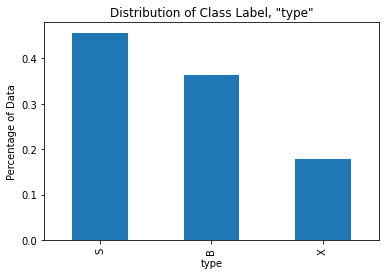

In [0]:
#First, we need to obtain the counts from the PySpark DF and grab the percentages
classes = df_pitch_2015_2018.groupBy('type').count().orderBy('count', ascending = False)
classes = classes.withColumn("percentage_of_data", calc_percentage_UDF(col("count")))
classes = classes.drop("count")

#Take resultant df and convert to pandas for graphing
plotting_df = classes.toPandas()

#Plot the distribution
plotting_df.plot(kind = 'bar', x = 'type', legend = False)
plt.ylabel("Percentage of Data")
plt.title("Distribution of Class Label, \"type\"")
plt.show()

##### Plot Remaining Categorical Bar Charts (% of Data)

Now, onto graphing the remaining categorical variables. We will first look at bar charts and get the % of total data that they represent.

In order to do this, we need to do a few things:
1. Derive a sample from our dataframe (it is quite large and we cannot comfortably use Pandas with nearly 2.5 million rows)
2. Develop a UDF to calculate the percentage of total sample that each value in a categorical variable represents
3. Create a plot_barchart function to plot each categorical variable

In [0]:
#Removing our label, "type"
remaining_cat_variables = ["code", "pitch_type", "nasty", "zone", "on_1b", "on_2b", "on_3b"]

#NOTE: Due to size of dataset, we will use a sample of 10% of the data to understand the distribution of the remaining categorical variables. Otherwise, it would take too long to run.
df_pitch_2015_2018_categorical_sample = df_pitch_2015_2018.select(categorical_variables).sample(fraction = 0.1, seed = 42)

row_count = df_pitch_2015_2018_categorical_sample.count()

In [0]:
#Now, we will create a function for reusability on the remaining columns
def plot_barchart(df, column):
    classes = df.groupBy(column).count().orderBy('count', ascending = False)
    classes = classes.withColumn("percentage_of_data", calc_percentage_UDF(col("count")))
    classes = classes.drop("count")
    plotting_df = classes.toPandas()
    plotting_df.plot(kind = 'bar', x = column, legend = False)
    plt.ylabel("Percentage of Data")
    plot_title = "Distribution of Categorical Variable: " + column
    plt.title(plot_title)
    plt.show()

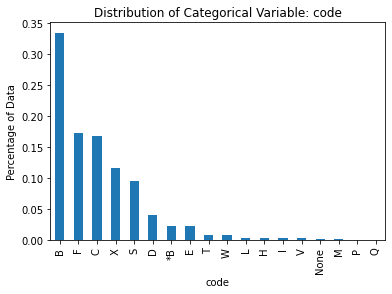

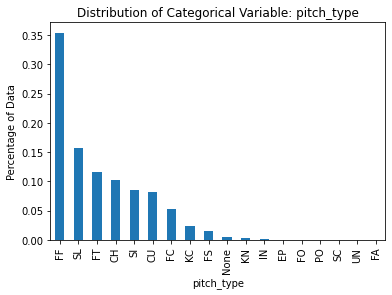

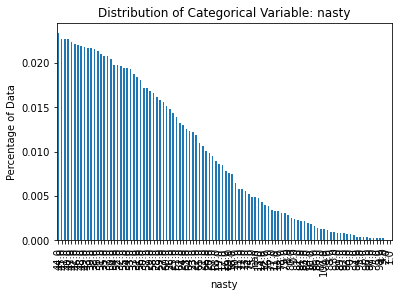

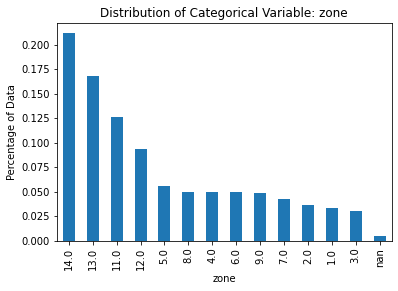

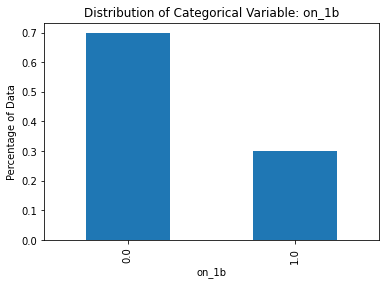

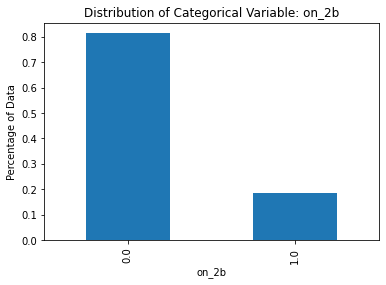

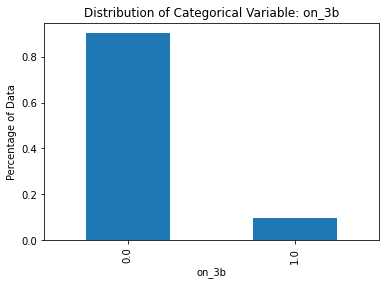

In [0]:
#Plotting categorical variables on barchart (not against class label)
for column in remaining_cat_variables:
    plot_barchart(df_pitch_2015_2018_categorical_sample, column)

##### Plot Categorical Bar Charts (Against Label)

Finally, we will put it all together - we will graph our variables against the label to understand the distribution of each relative to the classes we are trying to predict.

In [0]:
#Now, we will create a function for reusability on the remaining columns (this time, against the label)
def plot_barchart_against_label(df, column):
    classes = df.groupBy(column,"type").count()
    classes = classes.groupBy(column).pivot("type").sum("count")
    plotting_df = classes.toPandas()
    plotting_df.plot(kind = 'bar', x = column, legend = True)
    plt.ylabel("Count")
    plot_title = "Categorical Variable " + column + " Plotted against Label"
    plt.title(plot_title)
    plt.show()

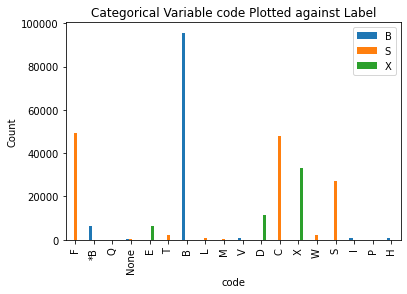

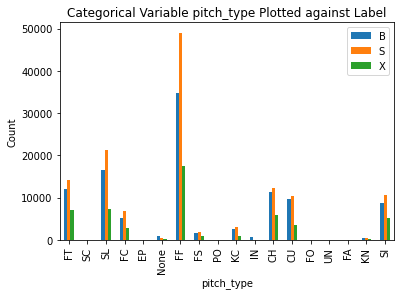

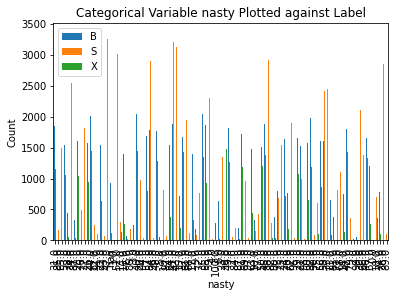

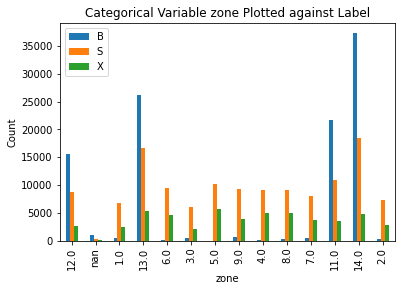

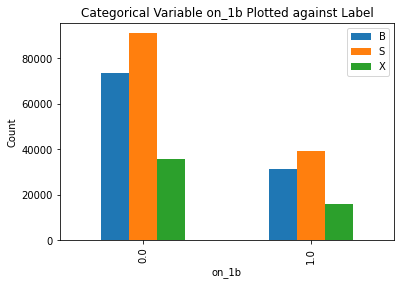

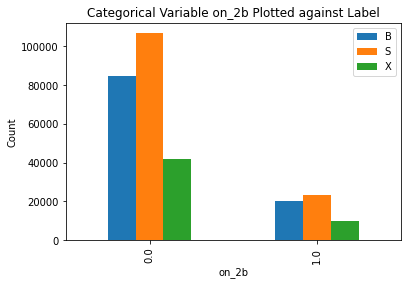

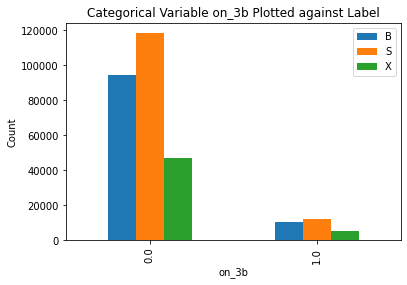

In [0]:
#Plotting categorical variables on barchart (this time, against the label)
for column in remaining_cat_variables:
    plot_barchart_against_label(df_pitch_2015_2018_categorical_sample, column)

#### EDA: Numeric (Categorical and Discrete) Data Fields

Next, we will look at the numeric side of our dataframe. 

We have far more variables of this type than we do of categorical ones. So, this will be a larger lift analytically.

In [0]:
#Create subset of numeric variables to analyze
numeric_variables = ["px", "pz", "start_speed", "end_speed", "spin_rate", "spin_dir", "break_angle", "break_length", "break_y", "ax", "ay", "az",
                    "sz_bot", "sz_top", "type_confidence", "vx0", "vy0", "vz0", "x", "x0", "y", "y0", "z0", "pfx_x", "pfx_z", 
                     "event_num", "b_score", "ab_id", "b_count", "s_count", "outs", "pitch_num"]

#Select subset of 2015-2018 pitch dataframe
df_pitch_2015_2018_numeric = df_pitch_2015_2018.select(numeric_variables)

In [0]:
#Examine descriptive statistics
df_pitch_2015_2018_numeric.describe().show()

+-------+--------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+--------------------+------------------+-------------------+-----------------+-----------------+------------------+--------------------+------------------+------------------+------------------+------------------+
|summary|                  px|                pz|      start_speed|        end_speed|         spin_rate|         spin_dir|       break_angle|      break_length|           break_y|                 ax|                ay|                 az|             sz_bot|             sz_top|   type_confidence|               vx0|                vy0|               vz0|                 x|

**Numeric Descriptive Statistics Analysis**

1. **px:** Missing just some rows. The mean is small, so the average ball thrown is dead-on as it comes across the plate. That said, standard deviation is nearly a foot either way!
2. **pz:** Missing just some rows. The average ball is a little over 2 feet above the dirt as it comes across the plate. Standard deviation is nearly a foot above or below.
3. **start_speed:** Missing just some rows. Average start speed is 88 mph. Standard deviation is 6 mph. So, they're throwing pretty fast on average, but less speedily than you'd expect (most elite pitchers are sending fastballs in the mid-high 90's).
4. **end_speed:** Missing just some rows. The average end speed is 81 mph. Standard deviation is 5 mph. Still getting to the plate fast, but tail-off of 7 mph in the aggregate.
5. **spin_rate:** Missing just some rows. The average RPM is 1731 and standard deviation is 683. This is likely very indicative of pitch type.
6. **spin_dir:** Missing just some rows. The average spin direction is 180 degrees, which is a vertical spin. Makes sense. Standard deviation is 67 degrees.
7. **break_angle:** Missing just some rows. The average breaking angle is 6 degrees, but standard deviation is 24 degrees. A lot of variablility.
8. **break_length:** Missing just some rows. The average break length is 6.6 inches from straight-line path. Standard deviation is 133 inches, though, which is very high. High variablility here as well.
9. **break_y:** Missing just some rows. The average distance from home plate where apogee is achieved is about 24 feet. Standard deviation is hardly any, so this is not going to be useful as a predictor.
10. **ax:** Missing just some rows. The average acceleration on the x-axis at release is just a smidge to the catcher's left, -2 feet per second per second. Standard deviation is pretty high here, though, at 11 feet per second per second.
11. **ay:** Missing just some rows. The average acceleration on the y-axis at release is 26 feet per second per second, and since this is relative to the catcher it means it's slowing down. Standard deviation is pretty low, only 4 feet per second per second.
12. **az:** Missing just some rows. The average acceleration on the z-axis at release is -23 feet per second per second, meaning it's going downward relative to the catcher. Standard deviation is moderate-high, nearly 9 feet per second per second. This likely has bearing on the pitch type.
13. **sz_bot:** Missing just some rows. The average measurement of bottom of strike zone is 1.6 feet from the dirt. Standard deviation is only .15 feet, not too much.
14. **sz_top:** Missing just some rows. The average measurement of top of strike zone is 3.4 feet from the dirt. Standard deviation is .22 feet, still not too much.
15. **type_confidence:** Missing just some rows. The average type confidence is 1.55 (pretty high) for the pitch type. Standard deviation is 0.55.
16. **vx0:** Missing just some rows. The initial pitch release velocity on x-axis is 2.3 feet per second, and standard deviation is huge at 6 feet per second.
17. **vy0:** Missing just some rows. The initial pitch release velocity on y-axis is -128 feet per second  (remember, all relative to catcher as origin point), and standard deviation is relatively small at 9 feet per second.
18. **vz0:** Missing just some rows. The initial pitch release velocity on z-axis is -4 feet per second, meaning it's going down. Standard deviation is 3 feet per second, meaning it's pretty large relative to the mean value.
19. **x:** Not missing ANY rows. Position is 116 on legacy Gameday coordinate system, which does not have an easy real-world positional translation. Standard deviation is 34, so it does have some distribution. NOTE: this is highly related with px, so we plan to drop this as it is redundant.
20. **x0:** Missing just some rows. This should tie with px, which is the at-the-plate version of this (again, this is taken from the release). This is -0.7 feet from middle at initial point, but standard deviation is 1.7 feet.
21. **y:** Not missing ANY rows. Position is 176 on legacy Gameday coordinate system, which does not have an easy real-world positional translation. Standard deviation is 30, so so it does have some distribution. NOTE: this actually corresponds with pz, so we plan to drop this as it is redundant.
22. **y0:** Missing just some rows. Average is 50, standard deviation is only 3 feet. Think we should just drop this one, it literally only tells you how far back the pitcher throws from. Maybe even just drop to only those where it's 50 feet just to be safe? We have so much data to work with.
23. **z0:** Missing just some rows. This should tie with pz, which is the at-the-plate version of this (again, this is taken from the release). Anyway, average height of ball is about 5.8 feet up when released. Though, the standard deviation is really high - 3.3 feet! Guess submarine pitchers and really tall guys add variability?
24. **pfx_x:** Missing just some rows. This is the delta value of x-axis, average is 1.1 inches to the left from pitcher POV. Standard deviation is only 0.46, which seems really low (espeically when you look at something like px - but I guess this is just the delta and that is positional, so it can work).
25. **pfx_z:** Missing just some rows. This is the delta value of the z-axis, average is 5 inches. This doesn't make much sense to me either, like why is this only a few inches when we know it starts up at 5 feet and goes down to 2 feet? Seems odd.
26. **event_num:** Not missing ANY rows. Not worth talking about - just a Foreign Key.
27. **b_score:** Not missing ANY rows. Average score of batter's team is 2.3, standard deviation is high at 2.6.
28. **ab_id:** Not missing ANY rows. Not worth talking about - just a Foreign Key.
29. **b_count:** Not missing ANY rows. Average balls in a given at-bat is 0.9, but standard deviation is about 1. Feel iffy including this, even though where they're at in ball/strike count is meaningful. Maybe table for now and come back to if prediction is not working well?
30. **s_count:** Not missing ANY rows. Average strikes in a given at-bat is 0.9 as well, standard deviation is less than balls at 0.8. Also feel iffy including this.
31. **outs:** Not missing ANY rows. Average number of outs before ball is thrown in given at-bat is 1, standard deviation is 0.8. Also feel iffy including this.
32. **pitch_num:** Not missing ANY rows. Average number of pitches is 2.9 in a given at-bat, standard deviation is 1.7. Also feel iffy including this.

##### Plot Numeric Variable Histograms

Moving on to graphing, our approach is similar to that for the categorical items:
1. Derive a sample (10%) of the dataframe prior to graphing
2. Obtain row_count value of numeric sample (should be the same as the categorical, but want to be safe)
3. Create a plot_histogram function that calculates the values for histograms and then pots them accordingly with MatPlotLib

In [0]:
#NOTE: Due to size of dataset, we will use a sample of 10% of the data to understand the distribution of the numeric variables. Otherwise, it would take too long to run.
df_pitch_2015_2018_numeric_sample = df_pitch_2015_2018.select(numeric_variables).sample(fraction = 0.1, seed = 42)

row_count = df_pitch_2015_2018_numeric_sample.count()

In [0]:
#First, create a "plot histogram" function for continuous variables
def plot_histogram(df, column, bins=20): 
    histogram_values = df.select(column).rdd.flatMap(lambda x: x).histogram(bins)
    
    width = histogram_values[0][1] - histogram_values[0][0]
    loc = [histogram_values[0][0] + (i+1) * width for i in range(len(histogram_values[1]))]
    
    plt.bar(loc, histogram_values[1], width=width)
    plt.xlabel(column)
    plt.ylabel("count")
    plt.show()

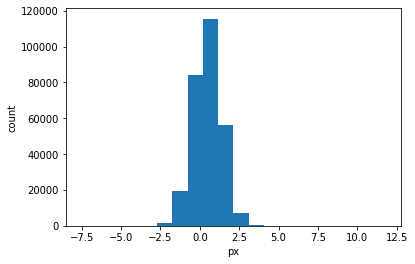

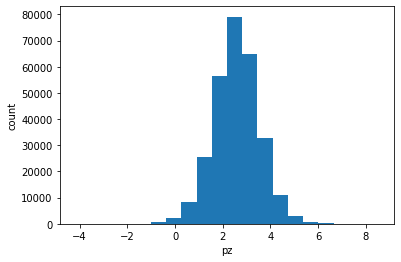

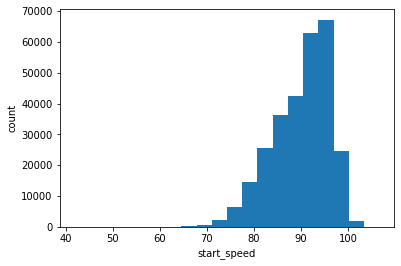

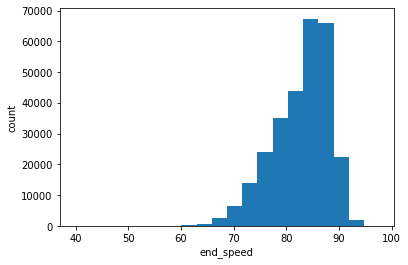

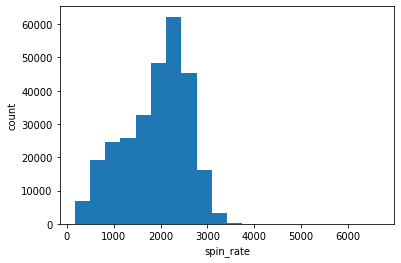

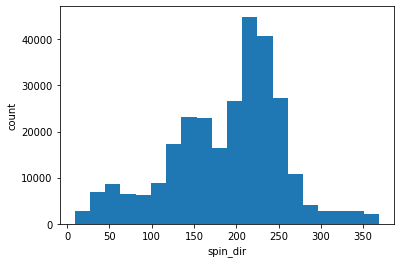

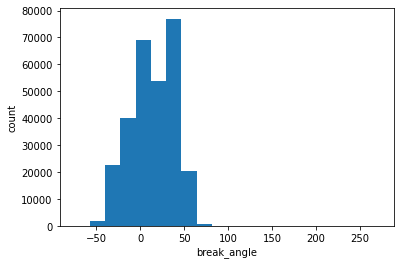

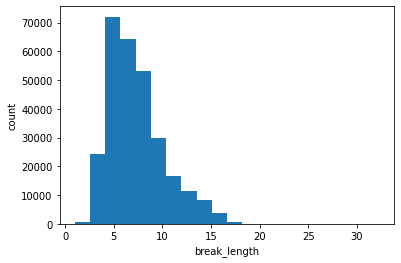

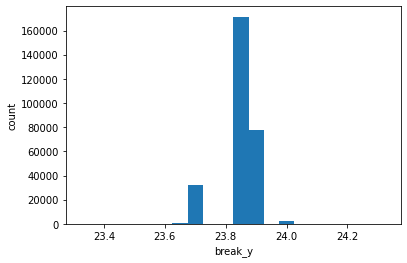

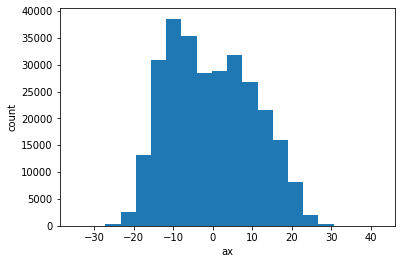

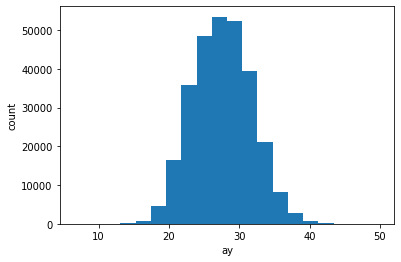

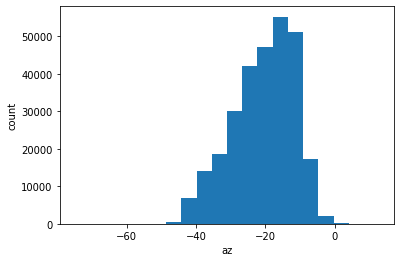

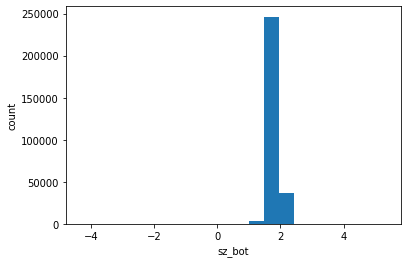

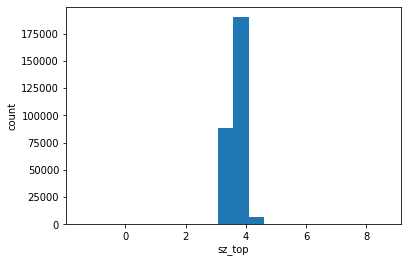

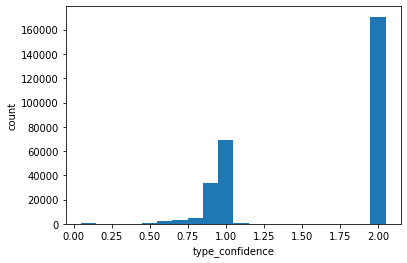

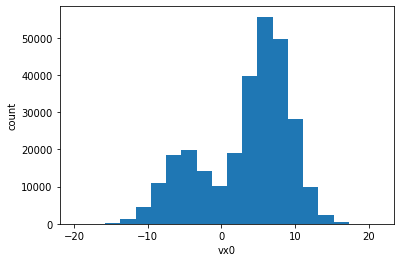

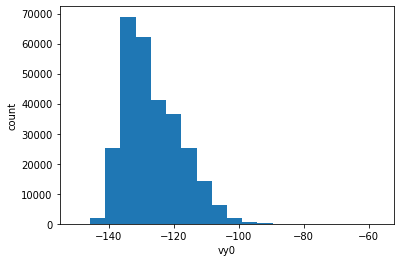

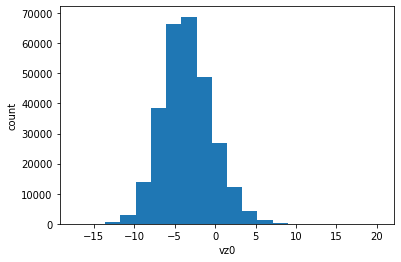

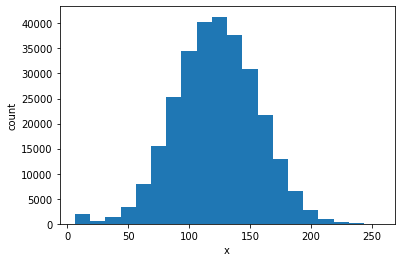

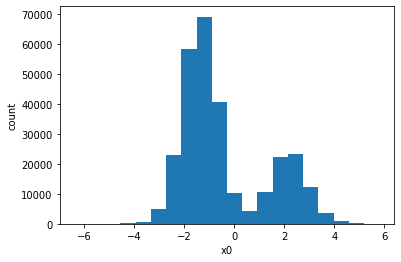

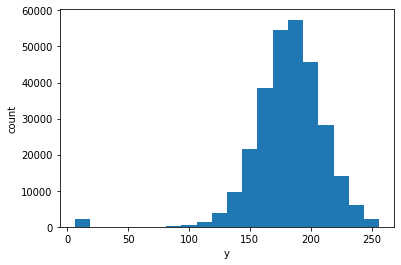

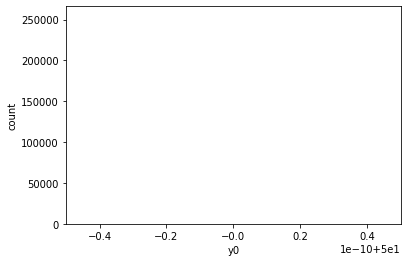

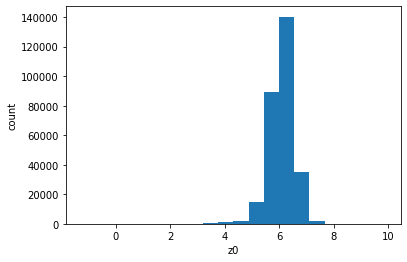

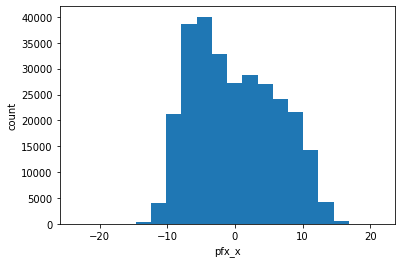

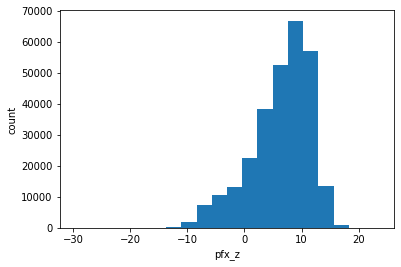

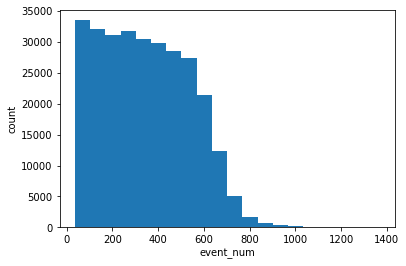

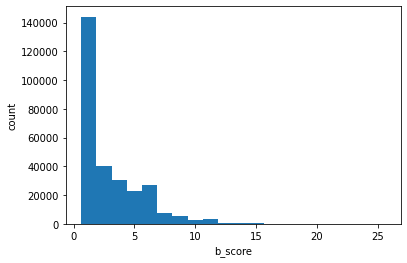

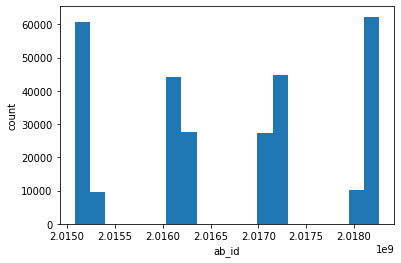

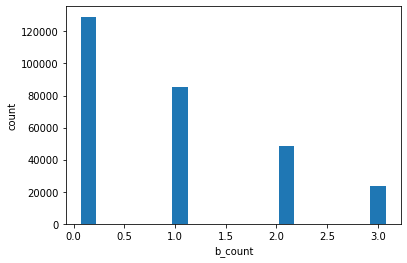

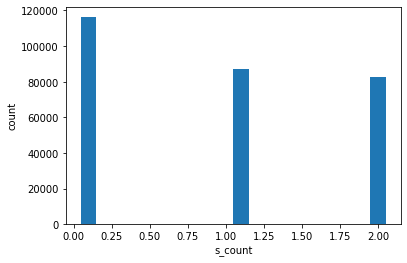

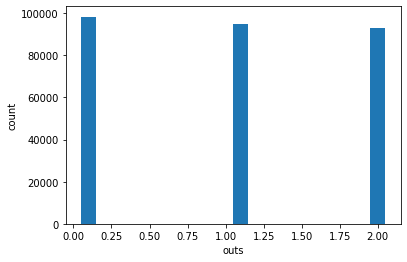

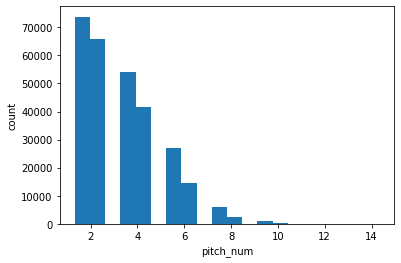

In [0]:
#Plotting numeric variables on histogram (not against class label)
for column in numeric_variables:
    plot_histogram(df_pitch_2015_2018_numeric_sample, column)

While there are many variables to examine, we can broadly say that there is enough skew among them (and a variety of scales) that we will need to use Robust Scaling in order to obtain successful predictions for our model.

##### Plot Numeric Variables Against Label (Boxplots)

As before, the final step is to plot the potential features against the label. Here, we will do so with boxplots. The formula is very similar to before:
1. Create a dataframe for our purposes, only containing 10% of the sample
2. Create a custom function to graph our potential features agains the label
3. Iterate through and produce visualizations

In [0]:
#NOTE: Here, we want to include the label with the numeric features. So, we'll resample that 10% and just include the column
numeric_variables_plus_label = ["px", "pz", "start_speed", "end_speed", "spin_rate", "spin_dir", "break_angle", "break_length", "break_y", "ax", "ay", "az",
                    "sz_bot", "sz_top", "type_confidence", "vx0", "vy0", "vz0", "x", "x0", "y", "y0", "z0", "pfx_x", "pfx_z", 
                     "event_num", "b_score", "ab_id", "b_count", "s_count", "outs", "pitch_num", "type"]

df_pitch_2015_2018_numeric_sample_plus_label = df_pitch_2015_2018.select(numeric_variables_plus_label).sample(fraction = 0.1, seed = 42).toPandas()

In [0]:
#Now, we will create a function for reusability for plotting continuous variables against the label
def plot_boxplot_against_label(df, col, group_by):  
    df.boxplot(col, by=group_by, figsize=(8, 5))
    plt.ylabel(col)
    plt.xlabel("label")
    title = "Variable: " + col
    plt.title(title)
    plt.show()

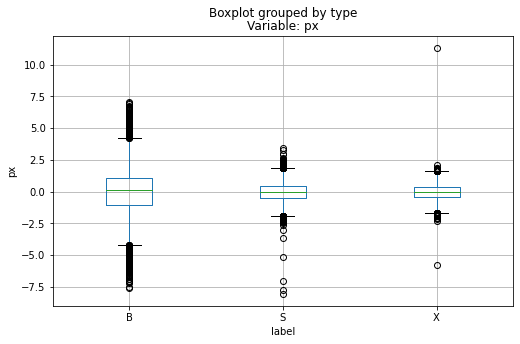

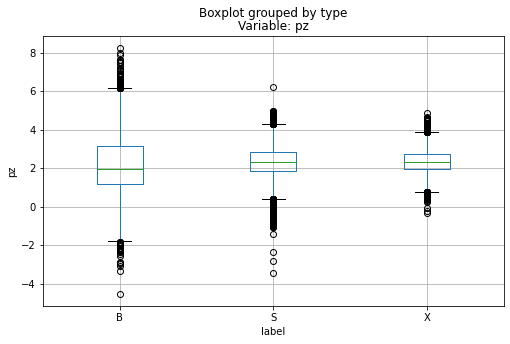

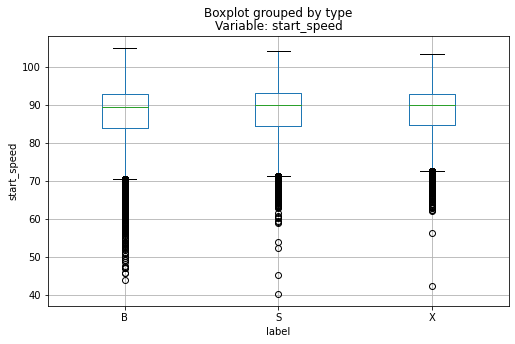

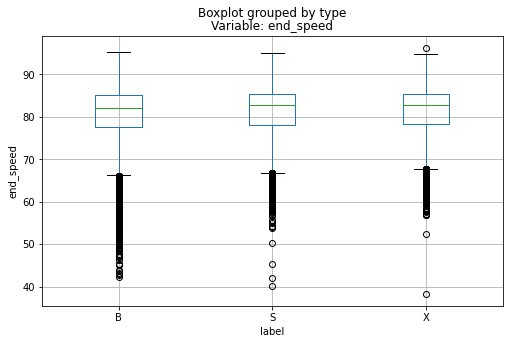

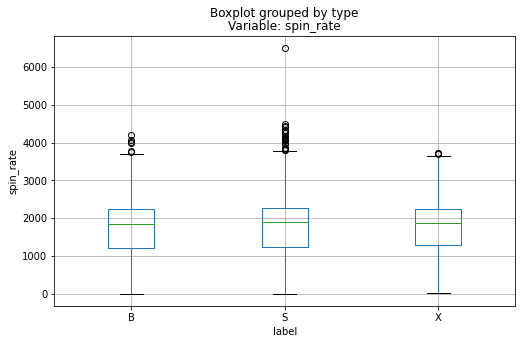

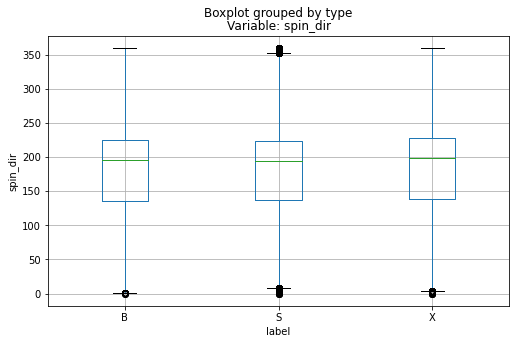

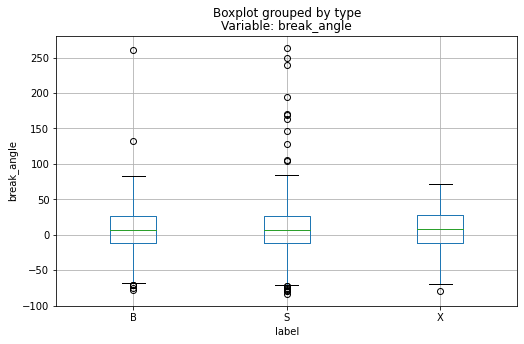

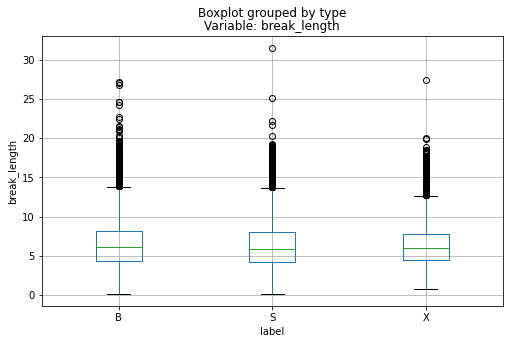

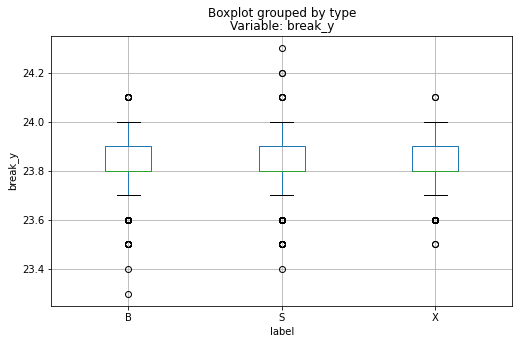

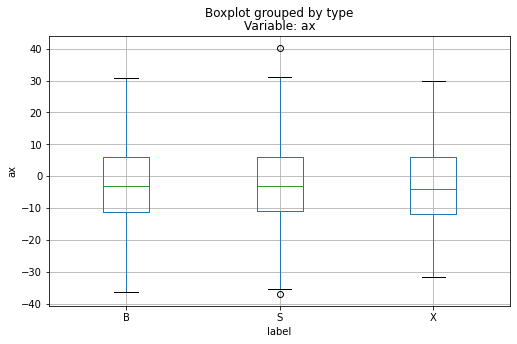

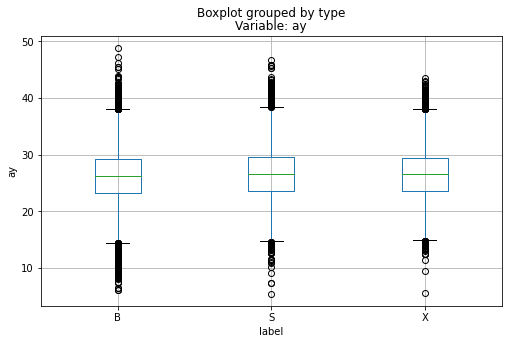

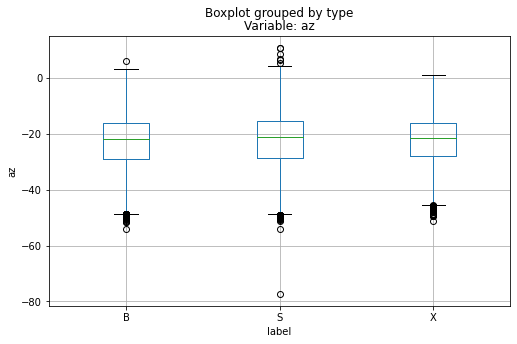

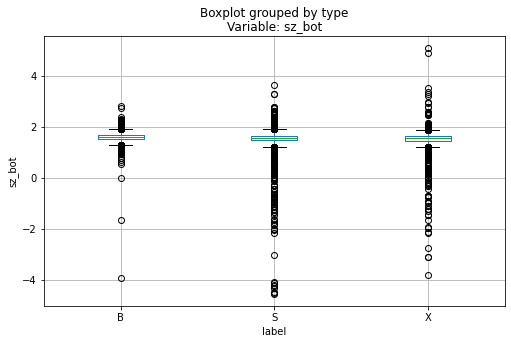

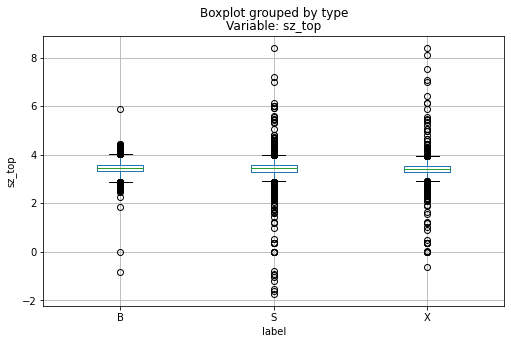

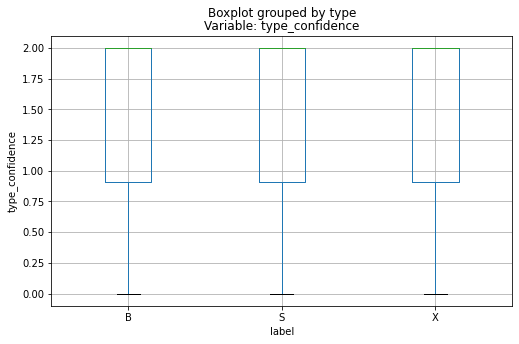

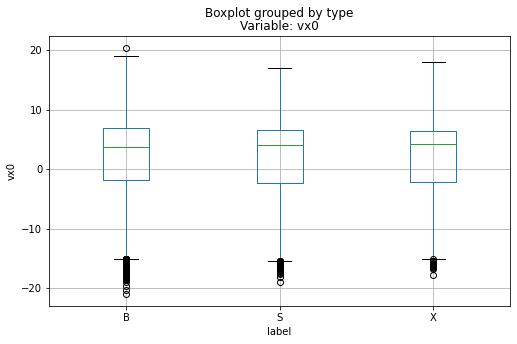

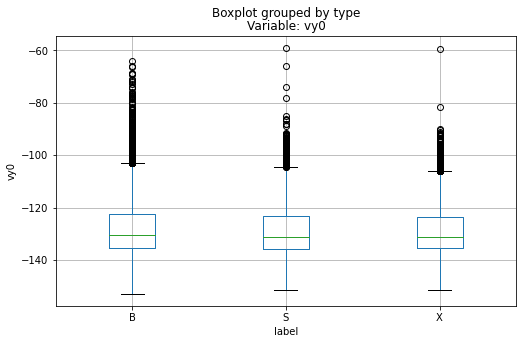

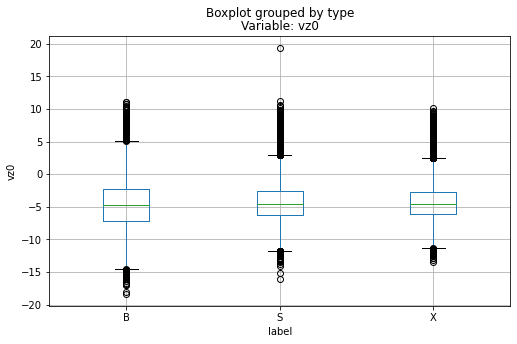

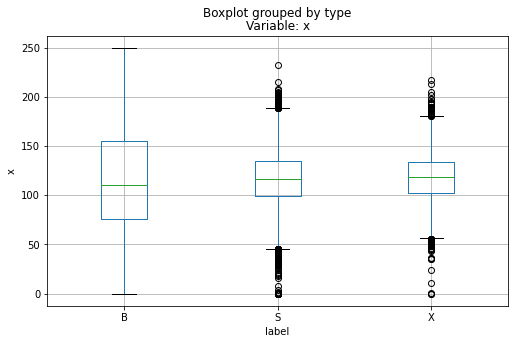

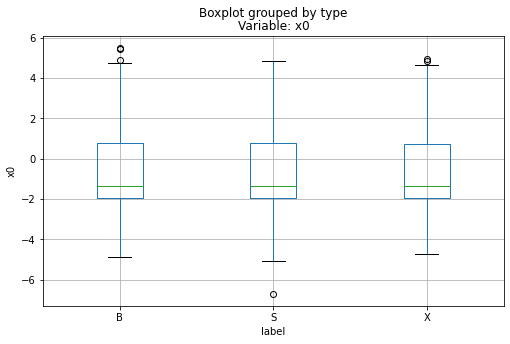

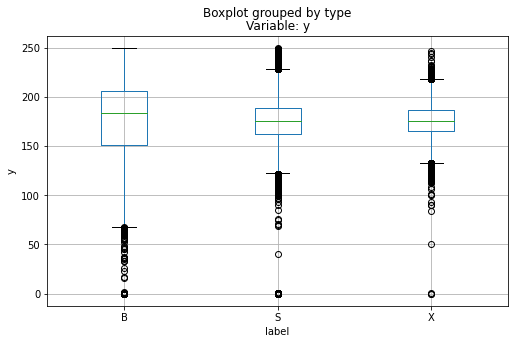

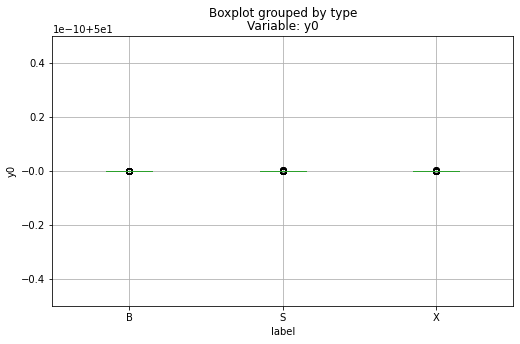

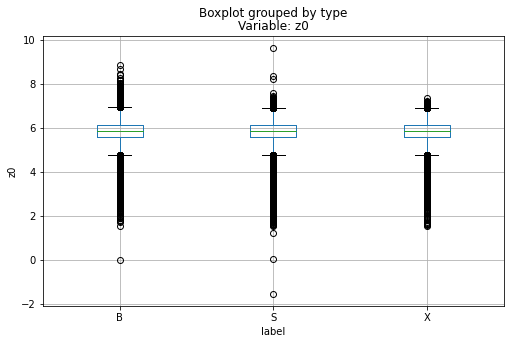

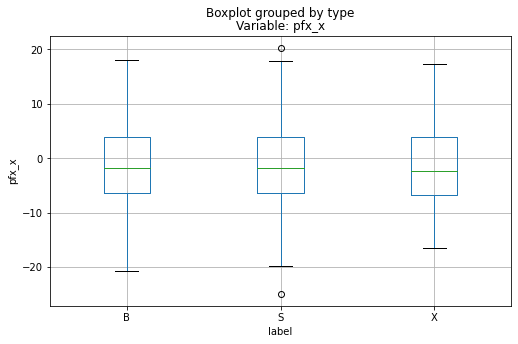

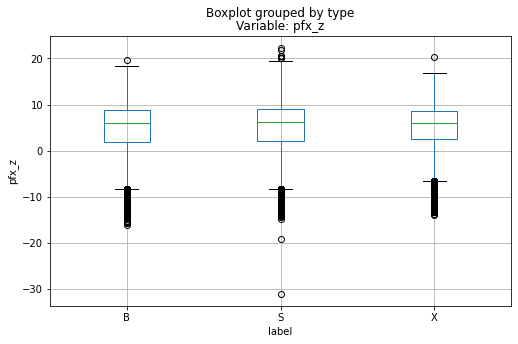

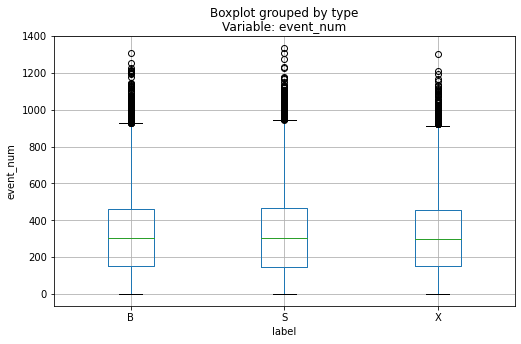

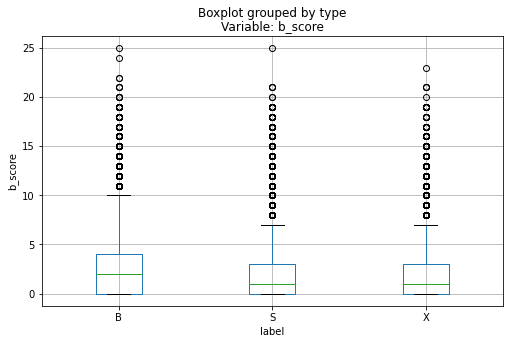

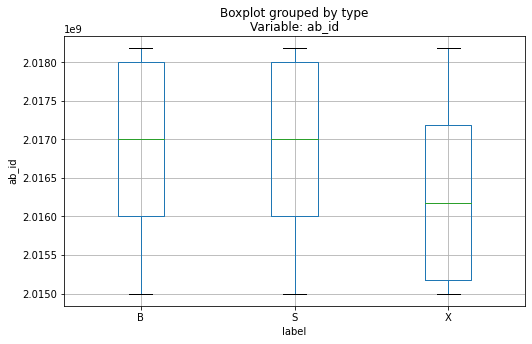

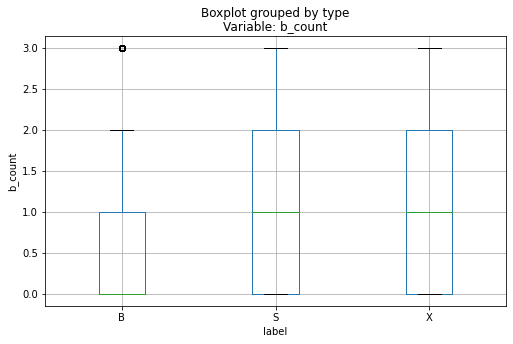

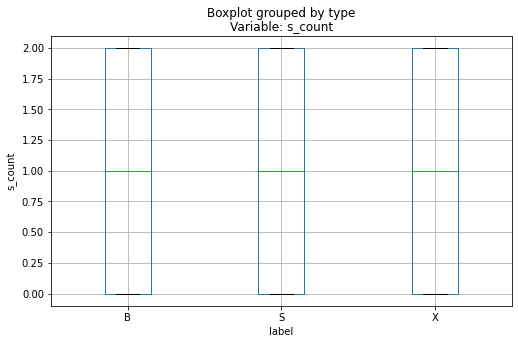

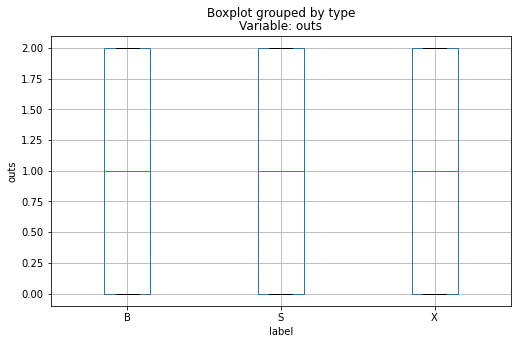

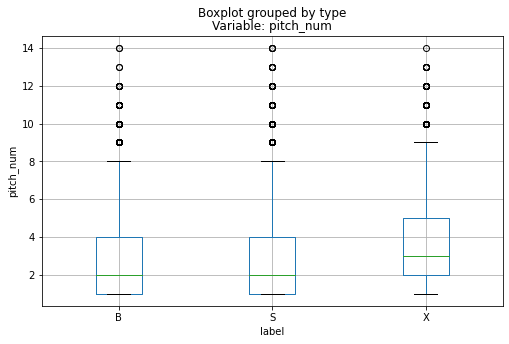

In [0]:
#Plotting numeric variables on boxplot (this time, against the label)
for column in numeric_variables:
    plot_boxplot_against_label(df_pitch_2015_2018_numeric_sample_plus_label, column, group_by="type")

Here, the large number of outliers in certain variables (ex: vz0, vy0, z0, and pfx_z) confirm our earlier thoughts - we will need to use Robust Scaling.

#### EDA: Examining Dataset for Nulls/Missing Values

As we already know from looking at some of our categorical features' labels, there are NULL values in this dataset. We will find which variable(s) these reside in, more specifically.

In [0]:
#Import relevant functions
from pyspark.sql.functions import when, count

#Now, we iterate through all variables and see which ones have null values (if any) - making sure that it's any type of null (even ones that have values labeled "None" or "NULL")
df_pitch_nulls = df_pitch_2015_2018.select([count(when(col(c).contains('None') | col(c).contains('NULL') | (col(c) == '' ) | col(c).isNull(), c)).alias(c) for c in df_pitch_2015_2018.columns])

df_pitch_nulls.show()

+-----+-----+-----------+---------+---------+--------+-----------+------------+-------+-----+-----+-----+------+------+---------------+-----+-----+-----+---+-----+---+-----+-----+-----+-----+-----+-----+----+----+----------+---------+-------+-----+-------+-------+----+---------+-----+-----+-----+
|   px|   pz|start_speed|end_speed|spin_rate|spin_dir|break_angle|break_length|break_y|   ax|   ay|   az|sz_bot|sz_top|type_confidence|  vx0|  vy0|  vz0|  x|   x0|  y|   y0|   z0|pfx_x|pfx_z|nasty| zone|code|type|pitch_type|event_num|b_score|ab_id|b_count|s_count|outs|pitch_num|on_1b|on_2b|on_3b|
+-----+-----+-----------+---------+---------+--------+-----------+------------+-------+-----+-----+-----+------+------+---------------+-----+-----+-----+---+-----+---+-----+-----+-----+-----+-----+-----+----+----+----------+---------+-------+-----+-------+-------+----+---------+-----+-----+-----+
|14189|14189|      14114|    14114|    14189|   14189|      14189|       14189|  14189|14189|14189|14189| 

## Pre-Processing / Feature Engineering

### Deal with Missing Values

In [0]:
#Drop all rows with nulls
df_pitch_cleaned = df_pitch_2015_2018.na.drop()

In [0]:
#Then, drop all where y0 is not 50FT (must be standard measurement distance, a few in the early days of the new system were measured from different mound distances)
df_pitch_cleaned = df_pitch_cleaned.filter(df_pitch_cleaned["y0"] == 50)

In [0]:
#Check that we have less rows now
cleaned_row_count = df_pitch_cleaned.count()

In [0]:
print(cleaned_row_count)

2527685


### Select Relevant Features

After examining the dataset, we have come to the conclusion that the following columns need to be dropped:
1. break_y: Little variation, limited use as predictor
2. sz_bot: Little variation, limited use as predictor
3. sz_bot: Little variation, limited use as predictor
4. type_confidence: Just gives confidence level for pitch_type variable, no use as predictor
5. x: Mostly a duplicate of px
6. y: Mostly a duplicate of pz
7. y0: Always 50ft, we have dropped anything else
8. nasty: High cardinality derived feature, limited use as predictor
9. zone: High cardinality derived feature, limited use as predictor
10. code: More detailed version of label variable "type", not useful for prediction
11. pitch_type: While helpful from an analytical standpoint, it is an aggregation of features we are already using. Thus, it is a "duplicate" in some sense of the word.
12. event_num: Foreign key to other tables in dataset
13. b_score: Not useful as a per-pitch predictor
14. s_count: Not useful as a per-pitch predictor
15. outs: Not useful as a per-pitch predictor
16. pitch_num: Not useful as a per-pitch predictor
17. on_1b: Not useful as a predictor
18. on_2b: Not useful as a predictor
19. on_3b: Not useful as a predictor

In [0]:
#Select relevant features (drop irrelevant)
#Dropping everything except for end_speed because using that for calculation of delta_speed
df_pitch_cleaned = df_pitch_cleaned.drop('break_y', 'sz_bot', 'sz_top', 'type_confidence', 'x', 'y', 'y0', 'nasty', 'zone', 'code', 'pitch_type', 'event_num',
                     'b_score', 'ab_id', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b')

### Create New Features (Based on Existing Variables), Relabel Columns for Ease of Use

We plan to create one new feature based on existing variables. In particular, we want to create a "delta_speed" variable to encapsulate velocity change better than having "end_speed" as a separate column.

In [0]:
#Relabel here ("withColumn")
df_pitch_cleaned = df_pitch_cleaned.withColumn('type_target', col('type'))
df_pitch_cleaned = df_pitch_cleaned.drop("type")

# Creating the derived column delta_speed from end_speed
df_pitch_cleaned = df_pitch_cleaned.withColumn('delta_speed', col('end_speed') - col('start_speed'))
df_pitch_cleaned.show()

+------+-----+-----------+---------+---------+--------+-----------+------------+------+------+-------+-------+--------+------+------+-----+-----+-----+-----------+-------------------+
|    px|   pz|start_speed|end_speed|spin_rate|spin_dir|break_angle|break_length|    ax|    ay|     az|    vx0|     vy0|   vz0|    x0|   z0|pfx_x|pfx_z|type_target|        delta_speed|
+------+-----+-----------+---------+---------+--------+-----------+------------+------+------+-------+-------+--------+------+------+-----+-----+-----+-----------+-------------------+
| 0.416|2.963|       92.9|     84.1| 2305.052| 159.235|      -25.0|         3.2| 7.665|34.685| -11.96| -6.409|-136.065|-3.995|  2.28|5.302| 4.16|10.93|          S| -8.800000000000011|
|-0.191|2.347|       92.8|     84.1| 2689.935| 151.402|      -40.7|         3.4|12.043|34.225|-10.085| -8.411| -135.69| -5.98| 2.119|5.307| 6.57| 12.0|          S| -8.700000000000003|
|-0.518|3.284|       94.1|     85.2| 2647.972| 145.125|      -43.7|         3.7|

In [0]:
# dropping the end_speed column
df_pitch_cleaned = df_pitch_cleaned.drop('end_speed')

In [0]:
df_pitch_cleaned.show()

+------+-----+-----------+---------+--------+-----------+------------+------+------+-------+-------+--------+------+------+-----+-----+-----+-----------+-------------------+
|    px|   pz|start_speed|spin_rate|spin_dir|break_angle|break_length|    ax|    ay|     az|    vx0|     vy0|   vz0|    x0|   z0|pfx_x|pfx_z|type_target|        delta_speed|
+------+-----+-----------+---------+--------+-----------+------------+------+------+-------+-------+--------+------+------+-----+-----+-----+-----------+-------------------+
| 0.416|2.963|       92.9| 2305.052| 159.235|      -25.0|         3.2| 7.665|34.685| -11.96| -6.409|-136.065|-3.995|  2.28|5.302| 4.16|10.93|          S| -8.800000000000011|
|-0.191|2.347|       92.8| 2689.935| 151.402|      -40.7|         3.4|12.043|34.225|-10.085| -8.411| -135.69| -5.98| 2.119|5.307| 6.57| 12.0|          S| -8.700000000000003|
|-0.518|3.284|       94.1| 2647.972| 145.125|      -43.7|         3.7|14.368|35.276| -11.56| -9.802|-137.668|-3.337| 2.127|5.313| 

### Examine Numeric Data for Multicollinearity
First, we make a list of the remaining features to assess. 

Then, we iterate through them in a nested manner, such that we obtain the correlation for all of the variable pairs in the dataset.

Specifically, we are using Pearson correlation. Any absolute values [above 0.8 are likely a sign of multicollinearity](http://article.sciappliedmathematics.com/pdf/ajams-8-2-1.pdf).

In [0]:
#Create list of remaining numeric features to assess for multicollinearity
remaining_numeric_features = ["px", "pz", "start_speed", "spin_rate", "spin_dir", "break_angle", "break_length", "ax", "ay", "az", "vx0", "vy0", "vz0", "x0", "z0", "pfx_x", "pfx_z", "delta_speed"]

In [0]:
#NOTE: Calculates Pearson Correlation Coefficient of two columns of a DataFrame.
#Docs: https://spark.apache.org/docs/1.6.1/api/java/org/apache/spark/sql/DataFrameStatFunctions.html
from pyspark.sql.functions import corr

#Find Pearson correlation between all variable pairs (numeric) in dataset

#First, instantiate an empty list to store our results
Pearson_corr_list = []

#Iterate through length of all numerical variables (outside of last, where we will have no further correlations to check)
for i in range(0, len(remaining_numeric_features)-1):
    column_i = remaining_numeric_features[i]
    
    #Iterate through columns in the list to the "right" of column i (start at 1 to the "right" of i until you get to the end of the list)
    for j in range(i + 1, len(remaining_numeric_features)):
        column_j = remaining_numeric_features[j]
        
        #Grab correlation from the pitch file
        col_ij_Pearson_corr = df_pitch_cleaned.corr(column_i, column_j)
        
        ##Save as a tuple and append to the list instantiated above
        Pearson_corr_tuple = (column_i, column_j, col_ij_Pearson_corr)
        Pearson_corr_list.append(Pearson_corr_tuple)
        
        j += 1
    i += 1

In [0]:
#Now, we will take a look at the results to determine which features may need to be pruned
for item in Pearson_corr_list:
    print(item)

('px', 'pz', -0.14022176940130995)
('px', 'start_speed', -0.02778406760766189)
('px', 'spin_rate', -0.05019650438125542)
('px', 'spin_dir', -0.16782962472406013)
('px', 'break_angle', -0.17196536695036574)
('px', 'break_length', 0.007244803367896252)
('px', 'ax', 0.16648164357568565)
('px', 'ay', -0.040212935919554355)
('px', 'az', -0.007840566210047292)
('px', 'vx0', 0.27383855144331626)
('px', 'vy0', 0.03407498874992335)
('px', 'vz0', -0.08820660393371879)
('px', 'x0', 0.05828180514944512)
('px', 'z0', -0.017255190643981313)
('px', 'pfx_x', 0.17446362237616442)
('px', 'pfx_z', -0.003764252659548572)
('px', 'delta_speed', 0.03698727002433793)
('pz', 'start_speed', 0.22543320591206295)
('pz', 'spin_rate', 0.18467388025519094)
('pz', 'spin_dir', 0.06875419711040835)
('pz', 'break_angle', 0.06555727093764802)
('pz', 'break_length', -0.29199809549097394)
('pz', 'ax', -0.04877955207199143)
('pz', 'ay', 0.20308072951009162)
('pz', 'az', 0.27277238169348456)
('pz', 'vx0', -0.0234463587221854

In short, the following pairs are suspect:
1. ('start_speed', 'break_length', -0.8499554902481677)
2. ('start_speed', 'vy0', -0.99808295963152)
3. ('break_angle', 'ax', -0.9652799356888536)
4. ('break_angle', 'pfx_x', -0.9445854654808056)
5. ('break_length', 'az', -0.9513317238664788)
6. ('break_length', 'vy0', 0.8494589303637048)
7. ('break_length', 'pfx_z', -0.9471783034801401)
8. ('ax', 'pfx_x', 0.9919339695024961)
9. ('ay', 'delta_speed', -0.8733018655743182)
10. ('az', 'pfx_z', 0.9874554681956039)
11. ('vx0', 'x0', -0.8868938009673939)

As such, we will remove the following columns from the dataset:
1. start_speed
2. break_angle
3. break_length
4. pfx_x
5. pfx_z

We are keeping both ay and delta_speed, as well as vx0 and x0, despite a high Pearson correlation score. ay is acceleration-related on only the y axis, while delta_speed is velocity-related (and measured slightly differently). vx0 is the initial velocity in the x direction, while x0 is the change in left-right distance in feet.

In [0]:
# dropping the all high multicollinearity columns
df_pitch_cleaned = df_pitch_cleaned.drop('start_speed', 'break_angle', 'break_length', 'pfx_x', 'pfx_z')

### Label (Nominal Categorical Variable) Treatment

Now, we will set up a string indexer for our label, type_target.

In [0]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='type_target', outputCol='label')

### Features (Numeric Variables) Treatment
Since all of our variables are numeric in nature, we are free to use robust scaling on the entire feature column.

As mentioned earlier, we have [outliers that would throw off a StandardScaler](https://proclusacademy.com/blog/robust-scaler-outliers/). So, we must use a RobustScaler in this case.

In [0]:
from pyspark.ml.feature import RobustScaler

features_robustscaler = RobustScaler().setInputCol("features").setOutputCol("Scaled_features")

### Create Pipeline for Transforming Data

We will use this pipeline to transform our data prior to modeling. It will consist of:
1. An indexer
2. A vector assembler
3. A robust scaler

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

#Create lists for columns to convert and feature columns
feature_cols = ["spin_rate", 'spin_dir', 'ax', 'ay', 'az', 'vx0', 'vy0', 'vz0', 'x0', 'z0', 'delta_speed']

#Create stages for transformation of data
stages = []
stages.append(indexer)
stages.append(VectorAssembler(inputCols=feature_cols, outputCol='features'))
stages.append(features_robustscaler)

#Create pipeline for this process
pipeline = Pipeline(stages=stages)

## Split Data into Train and Test, Apply Pipeline

Now, we can split our data into train and test dataframes and apply the pipeline appropriately.

We will split it into 80% for the train dataset and 20% for the test dataset.

In [0]:
pitch_train_df, pitch_test_df = df_pitch_cleaned.randomSplit([0.8, 0.2], seed = 42)

In [0]:
#Fit Pipeline to Train Dataset
pipeline_model = pipeline.fit(pitch_train_df)

#Transform Train Dataset
pitch_train_df_transformed = pipeline_model.transform(pitch_train_df)

#Transform Test Dataset
pitch_test_df_transformed = pipeline_model.transform(pitch_test_df)

## Model Building and Parameter Tuning
We will utilize a few libraries to create, tune, and evaluate our machine learning models.

Specifially, we plan to create a parameter grid for each of the 3 models we will run, and then we will evaluate with a multiclass classification evaluator.

In [0]:
#General Model Building
from pyspark.ml.evaluation import MulticlassClassificationEvaluator #Docs: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as f
import numpy as np

#Model 1 Needs
from pyspark.ml.classification import LogisticRegression

#Model 2 Needs
from pyspark.ml.classification import DecisionTreeClassifier

#Model 3 Needs
from pyspark.ml.classification import RandomForestClassifier

### MODEL 1: Logistic Regression
We will vary the following variables:
1. RegParam
2. ElasticNetParam

Then, we will obtain the best model from the cross-validator and use that to create predictions on the test dataset.

Finally, we grab only the prediction and label for use in the metrics section.

In [0]:
#Set up model
log_reg = LogisticRegression(featuresCol = "Scaled_features", labelCol = "label", maxIter = 10)

#Create param grid
paramGrid_lr = ParamGridBuilder() \
    .addGrid(log_reg.regParam, np.arange(0, .1, .01)) \
    .addGrid(log_reg.elasticNetParam, [0, 1]) \
    .build()

#Create crossvalidator
crossval_lr = CrossValidator(estimator = log_reg,
                          estimatorParamMaps = paramGrid_lr,
                          evaluator = MulticlassClassificationEvaluator(),
                          numFolds = 5)

In [0]:
#Fit model to training dataframe
cvModel_lr = crossval_lr.fit(pitch_train_df_transformed)

In [0]:
#Obtain best model
best_model_lr = cvModel_lr.bestModel.summary

#Gather coefficients and intercept
print("Coefficients: \n" + str(cvModel_lr.bestModel.coefficientMatrix))
print("Intercept: " + str(cvModel_lr.bestModel.interceptVector))

Coefficients: 
DenseMatrix([[-0.02829886, -0.02165452,  0.02933241, -0.01923915,  0.09390656,
               0.00049325,  0.00052883,  0.08180434, -0.0140651 ,  0.01505407,
              -0.09283144],
             [-0.02535193,  0.00060905,  0.03066411, -0.18599913, -0.13165911,
               0.07348426,  0.19616787, -0.27036007,  0.02930996, -0.0450453 ,
              -0.29655737],
             [ 0.05365079,  0.02104547, -0.05999652,  0.20523828,  0.03775254,
              -0.07397751, -0.1966967 ,  0.18855573, -0.01524486,  0.02999123,
               0.38938881]])
Intercept: [0.2652553630900016,1.7379923841931475,-2.003247747283149]


In [0]:
#Grab predictions for the train dataset
train_predictions_lr = best_model_lr.predictions

#Grab predictions for the test dataset
test_predictions_lr = cvModel_lr.transform(pitch_test_df_transformed)

In [0]:
#Isolate Prediction/Label pair and convert to RDD for evaluation metrics

#Train
prediction_label_lr_train = train_predictions_lr.select("prediction", "label")
prediction_label_lr_train = prediction_label_lr_train.rdd.map(lambda x: [x[0],x[1]])

#Test
prediction_label_lr_test = test_predictions_lr.select("prediction", "label")
prediction_label_lr_test = prediction_label_lr_test.rdd.map(lambda x: [x[0],x[1]])

### MODEL 2: Decision Tree
We will vary the following variables:
1. maxDepth
2. maxBins
3. impurity

In the same manner as Model 1, we obtain the best model from the cross-validator, use that to create predictions on the test dataset, and grab only the prediction and label for use in the metrics section.

In [0]:
#Set up model
dt = DecisionTreeClassifier(featuresCol = "Scaled_features", labelCol = "label")

#Create param grid
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 7]) \
    .addGrid(dt.maxBins, [8, 16, 32]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()

#Create crossvalidator
crossval_dt = CrossValidator(estimator = dt,
                          estimatorParamMaps = paramGrid_dt,
                          evaluator = MulticlassClassificationEvaluator(),
                          numFolds = 5)

In [0]:
#Fit model to training dataframe
cvModel_dt = crossval_dt.fit(pitch_train_df_transformed)

In [0]:
#Obtain best model
best_model_dt = cvModel_dt.bestModel

#Gather Feature Importances
best_model_dt.featureImportances

Out[183]: SparseVector(11, {1: 0.0006, 2: 0.0252, 4: 0.3124, 5: 0.0946, 6: 0.0301, 7: 0.3101, 8: 0.1095, 9: 0.1175})

In [0]:
#Grab predictions for the train dataset
train_predictions_dt = best_model_dt.transform(pitch_train_df_transformed)

#Grab predictions for the test dataset
test_predictions_dt = best_model_dt.transform(pitch_test_df_transformed)

In [0]:
#Isolate Prediction/Label pair and convert to RDD for evaluation metrics

#Train
prediction_label_dt_train = train_predictions_dt.select("prediction", "label")
prediction_label_dt_train = prediction_label_dt_train.rdd.map(lambda x: [x[0],x[1]])

#Test
prediction_label_dt_test = test_predictions_dt.select("prediction", "label")
prediction_label_dt_test = prediction_label_dt_test.rdd.map(lambda x: [x[0],x[1]])

### MODEL 3: Random Forest
We will vary the following variables:
1. impurity
2. maxDepth

In the same manner as Model 1 and 2, we obtain the best model from the cross-validator, use that to create predictions on the test dataset, and grab only the prediction and label for use in the metrics section.

In [0]:
#Set up model
rf = RandomForestClassifier(featuresCol = "Scaled_features", labelCol = "label", numTrees = 10)

#Create param grid
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.impurity, ['gini', 'entropy']) \
    .addGrid(rf.maxDepth, [5, 8, 10]) \
    .build()
  
#Create crossvalidator
crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)

In [0]:
#Fit model to training dataframe
cvModel_rf = crossval_rf.fit(pitch_train_df_transformed)

In [0]:
#Obtain best model
best_model_rf = cvModel_rf.bestModel.summary

In [0]:
#Grab predictions for the train dataset
train_predictions_rf = best_model_rf.predictions

#Grab predictions for the test dataset
test_predictions_rf = cvModel_rf.transform(pitch_test_df_transformed)

In [0]:
#Isolate Prediction/Label pair and convert to RDD for evaluation metrics

#Train
prediction_label_rf_train = train_predictions_rf.select("prediction", "label")
prediction_label_rf_train = prediction_label_rf_train.rdd.map(lambda x: [x[0],x[1]])

#Test
prediction_label_rf_test = test_predictions_rf.select("prediction", "label")
prediction_label_rf_test = prediction_label_rf_test.rdd.map(lambda x: [x[0],x[1]])

## Results Evaluation and Interpretation
We use mllib's evaluator for multiclass metrics to obtain the following types of metrics on our models for train and test:
1. Confusion Matrix
2. Accuracy
3. Weighted Recall
4. Weighted Precision
5. Weighted F(1) Score
6. By-Class Metrics of Precision, Recall, and F(1)

In [0]:
#Import Multiclass Classification Metrics
from pyspark.mllib.evaluation import MulticlassMetrics

#Obtain labels (for use in "by class" statistics)
labels = pitch_train_df_transformed.select(f.collect_set('label').alias('label')).first()['label']

### Model 1: LOGISTIC REGRESSION

In [0]:
train_metrics_lr.accuracy

Out[179]: 0.5198443033355519

In [0]:
train_metrics_lr = MulticlassMetrics(prediction_label_lr_train)
test_metrics_lr = MulticlassMetrics(prediction_label_lr_test)


### TRAINING METRIC RESULTS ###
print("### LR: TRAIN METRIC RESULTS ###")

#TRAIN: Confusion Matrix
print("Confusion Matrix:")
print(train_metrics_lr.confusionMatrix())
print()

print("Accuracy:")
print(train_metrics_lr.accuracy)
print()

#TRAIN: Weighted Summary Statistics
print("Weighted Summary Statistics:")
print("Weighted recall = ", train_metrics_lr.weightedRecall)
print("Weighted precision = ", train_metrics_lr.weightedPrecision)
print("Weighted F(1) Score = ", train_metrics_lr.weightedFMeasure())
print()

#TRAIN: Statistics By Class
for label in sorted(labels):
    print("Class %s:" % label)
    print("Class %s precision = %s" % (label, train_metrics_lr.precision(label)))
    print("Class %s recall = %s" % (label, train_metrics_lr.recall(label)))
    print("Class %s F1 Measure = %s" % (label, train_metrics_lr.fMeasure(label, beta = 1.0)))
    print()
    
print()


### TEST METRIC RESULTS ###
print("### LR: TEST METRIC RESULTS ###")

#TEST: Confusion Matrix
print("Confusion Matrix:")
print(test_metrics_lr.confusionMatrix())
print()

print("Accuracy:")
print(test_metrics_lr.accuracy)
print()

#TEST: Weighted Summary Statistics
print("Weighted Summary Statistics:")
print("Weighted recall = ", test_metrics_lr.weightedRecall)
print("Weighted precision = ", test_metrics_lr.weightedPrecision)
print("Weighted F(1) Score = ", test_metrics_lr.weightedFMeasure())
print()

#TEST: Statistics By Class
for label in sorted(labels):
    print("Class %s:" % label)
    print("Class %s precision = %s" % (label, test_metrics_lr.precision(label)))
    print("Class %s recall = %s" % (label, test_metrics_lr.recall(label)))
    print("Class %s F1 Measure = %s" % (label, test_metrics_lr.fMeasure(label, beta = 1.0)))
    print()
    
print()

### LR: TRAIN METRIC RESULTS ###
Confusion Matrix:
DenseMatrix([[8.32867e+05, 8.58580e+04, 4.00000e+00],
             [5.30060e+05, 2.18460e+05, 3.00000e+00],
             [3.36925e+05, 1.82140e+04, 3.00000e+00]])

Accuracy:
0.5198443033355519

Weighted Summary Statistics:
Weighted recall =  0.5198443033355519
Weighted precision =  0.5259523189681891
Weighted F(1) Score =  0.43996216274612

Class 0.0:
Class 0.0 precision = 0.4899644204318964
Class 0.0 recall = 0.9065426257362073
Class 0.0 F1 Measure = 0.6361208608784681

Class 1.0:
Class 1.0 precision = 0.6773281410836755
Class 1.0 recall = 0.29185475930599325
Class 1.0 F1 Measure = 0.40793423306926346

Class 2.0:
Class 2.0 precision = 0.3
Class 2.0 recall = 8.44732529523402e-06
Class 2.0 F1 Measure = 1.6894174888498443e-05


### LR: TEST METRIC RESULTS ###
Confusion Matrix:
DenseMatrix([[2.07566e+05, 2.15720e+04, 2.00000e+00],
             [1.32680e+05, 5.45210e+04, 2.00000e+00],
             [8.42900e+04, 4.65800e+03, 0.00000e+00]])


Overall, we see accuracy is low on both the train and the test datsets. The weighted summary statistics tell a similar story, where we see an especially low F(1). 

In general, there is little difference between train and test - so the model performs poorly, but generalizes well.

Finally, we can see that this model is very good at predicting Class 0 label (strikes), which is a strength.

### Model 2: DECISION TREE

In [0]:
train_metrics_dt = MulticlassMetrics(prediction_label_dt_train)
test_metrics_dt = MulticlassMetrics(prediction_label_dt_test)


### TRAINING METRIC RESULTS ###
print("### DT: TRAIN METRIC RESULTS ###")

#TRAIN: Confusion Matrix
print("Confusion Matrix:")
print(train_metrics_dt.confusionMatrix())
print()

print("Accuracy:")
print(train_metrics_dt.accuracy)
print()

#TRAIN: Weighted Summary Statistics
print("Weighted Summary Statistics:")
print("Weighted recall = ", train_metrics_dt.weightedRecall)
print("Weighted precision = ", train_metrics_dt.weightedPrecision)
print("Weighted F(1) Score = ", train_metrics_dt.weightedFMeasure())
print()

#TRAIN: Statistics By Class
for label in sorted(labels):
    print("Class %s:" % label)
    print("Class %s precision = %s" % (label, train_metrics_dt.precision(label)))
    print("Class %s recall = %s" % (label, train_metrics_dt.recall(label)))
    print("Class %s F1 Measure = %s" % (label, train_metrics_dt.fMeasure(label, beta = 1.0)))
    print()
    
print()


### TEST METRIC RESULTS ###
print("### DT: TEST METRIC RESULTS ###")

#TEST: Confusion Matrix
print("Confusion Matrix:")
print(test_metrics_dt.confusionMatrix())
print()

print("Accuracy:")
print(test_metrics_dt.accuracy)
print()

#TEST: Weighted Summary Statistics
print("Weighted Summary Statistics:")
print("Weighted recall = ", test_metrics_dt.weightedRecall)
print("Weighted precision = ", test_metrics_dt.weightedPrecision)
print("Weighted F(1) Score = ", test_metrics_dt.weightedFMeasure())
print()

#TEST: Statistics By Class
for label in sorted(labels):
    print("Class %s:" % label)
    print("Class %s precision = %s" % (label, test_metrics_dt.precision(label)))
    print("Class %s recall = %s" % (label, test_metrics_dt.recall(label)))
    print("Class %s F1 Measure = %s" % (label, test_metrics_dt.fMeasure(label, beta = 1.0)))
    print()
    
print()

### DT: TRAIN METRIC RESULTS ###
Confusion Matrix:
DenseMatrix([[759777., 158952.,      0.],
             [385659., 362864.,      0.],
             [307522.,  47620.,      0.]])

Accuracy:
0.5551049894333152

Weighted Summary Statistics:
Weighted recall =  0.5551049894333152
Weighted precision =  0.4734011766193307
Weighted F(1) Score =  0.49486196046009534

Class 0.0:
Class 0.0 precision = 0.5229173864626506
Class 0.0 recall = 0.8269870658268107
Class 0.0 F1 Measure = 0.6407059616214111

Class 1.0:
Class 1.0 precision = 0.6372340350803251
Class 1.0 recall = 0.48477334697798197
Class 1.0 F1 Measure = 0.5506453539146514

Class 2.0:
Class 2.0 precision = 0.0
Class 2.0 recall = 0.0
Class 2.0 F1 Measure = 0.0


### DT: TEST METRIC RESULTS ###
Confusion Matrix:
DenseMatrix([[189425.,  39715.,      0.],
             [ 96792.,  90411.,      0.],
             [ 77129.,  11819.,      0.]])

Accuracy:
0.5538115660084981

Weighted Summary Statistics:
Weighted recall =  0.5538115660084981
Weighted

Accuracy has improved for the Decision Tree versus the Logistic Regression. We see that it is now better than chance.

This model still is very poor at predicting Class 2.0 (In Play).

### Model 3: RANDOM FOREST

In [0]:
train_metrics_rf = MulticlassMetrics(prediction_label_rf_train)
test_metrics_rf = MulticlassMetrics(prediction_label_rf_test)


### TRAINING METRIC RESULTS ###
print("### RF: TRAIN METRIC RESULTS ###")

#TRAIN: Confusion Matrix
print("Confusion Matrix:")
print(train_metrics_rf.confusionMatrix())
print()

print("Accuracy:")
print(train_metrics_rf.accuracy)
print()

#TRAIN: Weighted Summary Statistics
print("Weighted Summary Statistics:")
print("Weighted recall = ", train_metrics_rf.weightedRecall)
print("Weighted precision = ", train_metrics_rf.weightedPrecision)
print("Weighted F(1) Score = ", train_metrics_rf.weightedFMeasure())
print()

#TRAIN: Statistics By Class
for label in sorted(labels):
    print("Class %s:" % label)
    print("Class %s precision = %s" % (label, train_metrics_rf.precision(label)))
    print("Class %s recall = %s" % (label, train_metrics_rf.recall(label)))
    print("Class %s F1 Measure = %s" % (label, train_metrics_rf.fMeasure(label, beta = 1.0)))
    print()
    
print()


### TEST METRIC RESULTS ###
print("### RF: TEST METRIC RESULTS ###")

#TEST: Confusion Matrix
print("Confusion Matrix:")
print(test_metrics_rf.confusionMatrix())
print()

print("Accuracy:")
print(test_metrics_rf.accuracy)
print()

#TEST: Weighted Summary Statistics
print("Weighted Summary Statistics:")
print("Weighted recall = ", test_metrics_rf.weightedRecall)
print("Weighted precision = ", test_metrics_rf.weightedPrecision)
print("Weighted F(1) Score = ", test_metrics_rf.weightedFMeasure())
print()

#TEST: Statistics By Class
for label in sorted(labels):
    print("Class %s:" % label)
    print("Class %s precision = %s" % (label, test_metrics_rf.precision(label)))
    print("Class %s recall = %s" % (label, test_metrics_rf.recall(label)))
    print("Class %s F1 Measure = %s" % (label, test_metrics_rf.fMeasure(label, beta = 1.0)))
    print()
    
print()

### RF: TRAIN METRIC RESULTS ###
Confusion Matrix:
DenseMatrix([[815333., 103396.,      0.],
             [341472., 407051.,      0.],
             [329127.,  26015.,      0.]])

Accuracy:
0.6044242615434975

Weighted Summary Statistics:
Weighted recall =  0.6044242615434975
Weighted precision =  0.5300966702938947
Weighted F(1) Score =  0.5425459704911454

Class 0.0:
Class 0.0 precision = 0.5487014210609906
Class 0.0 recall = 0.8874575636558768
Class 0.0 F1 Measure = 0.6781271871586056

Class 1.0:
Class 1.0 precision = 0.7587694934589961
Class 1.0 recall = 0.5438056011638921
Class 1.0 F1 Measure = 0.6335498079744122

Class 2.0:
Class 2.0 precision = 0.0
Class 2.0 recall = 0.0
Class 2.0 F1 Measure = 0.0


### RF: TEST METRIC RESULTS ###
Confusion Matrix:
DenseMatrix([[203053.,  26087.,      0.],
             [ 85841., 101362.,      0.],
             [ 82483.,   6465.,      0.]])

Accuracy:
0.6024548230623542

Weighted Summary Statistics:
Weighted recall =  0.6024548230623542
Weighted p

Accuracy is the best of all the model types - 60%. Class 0 (Strikes) has high recall and Class 1 (Balls) has high precision. But Class 2 (In-Play) predictive power is nonexistent. So, the model is essentially predicting between balls and strikes only.